# Reading gds files 

In [3]:
from Libraries_Functions import np, plt, unp, wmean, ur, umean, os, pd, calculate_stage_info,\
ufloat,convert_uncertainties, convert_uncertainty_columns, calculate_stage_info_all,\
calculate_centroid, A, V, ur, umean, wmean, calculate_stage_info_base, calculate_stage_info,\
calculate_total_info, convert_uncertainties,convert_uncertainty_columns, interpolate, stats,\
patches, Polygon, Axes3D, PercentFormatter, MultipleLocator, FuncFormatter, math, ransac,\
uncertainties, unp, EllipseModel, widgets, sns, mpc, mpld3, ufloat_fromstr, BlendedGenericTransform,\
Ellipse, widgets, sns, Filter_outliers

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

pd.set_option('future.no_silent_downcasting', True)


Number of rows of data in NC04:  460748

Index(['Stage Number', 'Time since start of test (s)',
       'Time since start of stage (s)', 'Radial Pressure (kPa)',
       'Radial Volume (mm³)', 'Back Pressure (kPa)', 'Back Volume (mm³)',
       'Load Cell (kN)', 'Pore Pressure (kPa)', 'Axial Displacement (mm)',
       'L/C Pressure (kPa)', 'L/C Volume (mm³)', 'Local Axial 1 (mm)',
       'Local Axial 2 (mm)', 'Local Radial (mm)', 'Base Pressure (kPa)',
       'Base Volume (mm³)', 'Back Differential Pressure (kPa)',
       'Axial Displacement 2 (mm)', 'Pore Air Pressure (kPa)',
       'Pore Air Volume (mm³)', 'Atmospheric Pressure (kPa)',
       'Temperature (°C)', 'Mid Plane PWP (kPa)',
       'Back to Cell Differential (kPa)', 'Total Volume Change (mm³)',
       'Undefined Tx 1', 'Undefined Tx 2', 'Undefined Tx 3',
       'Axial Force (kN)', 'Axial Strain (%)', 'Av Diameter Change (mm)',
       'Radial Strain (%)', 'Axial Stress (kPa)', 'Eff. Axial Stress (kPa)',
       'Eff. Radial Str

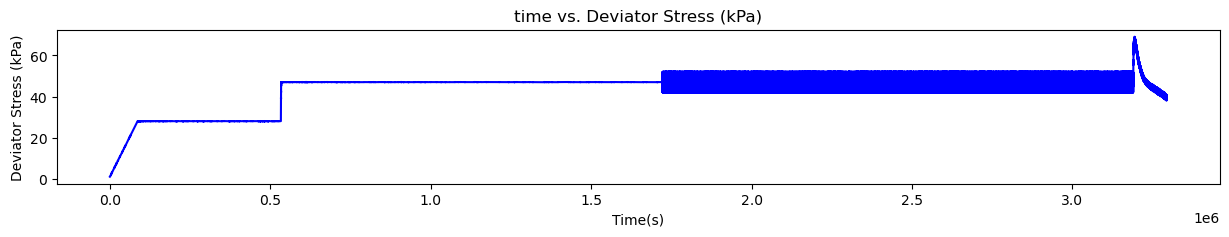

In [4]:
"""Read gds files, skipping the first 28-30 rows and setting the 31st row as the header"""

#current_directory = os.path.dirname(os.path.abspath(__file__))
Path_NC04 = os.path.join(os.getcwd(), 'gds_files', 'NC04.gds')
df_NC04 = pd.read_csv(Path_NC04, header=29, encoding='latin1')

print()
print("Number of rows of data in NC04: ", len(df_NC04))
print()
print(df_NC04.columns)

plt.figure(figsize=(15, 2)) 
plt.plot(df_NC04['Time since start of test (s)'], df_NC04['Deviator Stress (kPa)'], color='b')        # Deviator Stress (kPa)
plt.xlabel("Time(s)")
plt.ylabel("Deviator Stress (kPa)")
plt.title('time vs. Deviator Stress (kPa)')
plt.show()

# Propogation error

In [5]:
""" The ingiven Data of the sample and Propogation error in Stress, Strain, pwp and deviator stress
"""
## Poisson's ratio
v = 0.2  
#the Uncertainties in the measurements
Ru_d_G = 0.0002      #    Relative Uncertainty in Global displacement sensor
Ru_d_L = 0.00105     #    Relative Uncertainty in Local displacement sensor 
Ru_l = 0.00          #    Relative Uncertainty in axial loading sensor 
v_error = 0.018      # mm Relative Uncertainty in vernier caliper 
Ru_c3 = 0.0086       #    Relative Uncertainty in cell pressure  
Ru_w = 0.0035        #    Relative Uncertainty in pore pressure  

## NC
###
H0_NC04 = 100                 # mm  initial height
D0_NC04 = 50                  # mm  initial diameter 
A0_NC04 = A(D0_NC04)          # m^2
V0_NC04 = V(A0_NC04, H0_NC04/1000) # m^3


d_error_LCC = 0 # mm
Ru_A_NC04 = (2 * d_error_LCC)/(D0_NC04)                                           #  Relative Uncertainty in Area
Ru_H_G_NC04 = (v_error/H0_NC04)                                                #  Relative Uncertainty in change of the hieght of specimne for global strain.                                           #  Relative Uncertainty in change of the hieght of specimne for local strain.   
Ru_strain_G_NC04 = np.sqrt(((Ru_d_G)**2) + ((Ru_H_G_NC04)**2))                 #  Relative Uncertainty in Global strain
Ru_stress_NC04 = np.sqrt(((Ru_l)**2) + ((Ru_A_NC04)**2))                       #  Relative Uncertainty in Local stress
Ru_E_G_NC04 = np.sqrt(((Ru_stress_NC04)**2) + ((Ru_strain_G_NC04)**2))                       #  Relative Uncertainty in global E
#Ru_Deviatoric_stress_NC04 = np.sqrt(((Ru_stress_NC04)**2) + ((Ru_c3)**2))      # Relative Uncertainty in deviatoric stress



""" The peak deviatoric stress (qf ) which is taken from monotonic tests, in our study the value is 
no available, so the value is taken from other research which search the same soil and site ((Wong et al., 2023, p. 7)"""

Su_NC = 33   ##  kPa The undrained shear strength was determined from the monotonic tests 
qf_NC = 66 



""" New columns of propagation error for stress, strain, eff.stress, deviator stress, radial stress and pwp.
"""

"""NC04
"""

df_NC04_P = df_NC04.copy()

#  local strain and global strain as decimel, not precentage. 
df_NC04_P['Global Axial Strain'] = df_NC04_P['Axial Strain (%)'] / 100

# Stress uncertainty
df_NC04_P['Axial Stress & Uncertainty (kPa)'] = df_NC04_P.apply(lambda row: ufloat(row['Axial Stress (kPa)'], Ru_stress_NC04 * np.abs(row['Axial Stress (kPa)'])), axis=1)


# Global strain uncertainty
df_NC04_P['Global Axial Strain & Uncertainty'] = df_NC04_P.apply(lambda row: ufloat(row['Global Axial Strain'], Ru_strain_G_NC04 * np.abs(row['Global Axial Strain'])), axis=1)


# Radial pressure uncertainty
df_NC04_P['Radial Pressure & Uncertainty (kPa)'] = df_NC04_P.apply(lambda row: ufloat(row['Radial Pressure (kPa)'], Ru_c3 * np.abs(row['Radial Pressure (kPa)'])), axis=1)


# deviatoric uncertainty
df_NC04_P['Error Deviator Stress (kPa)'] = ((unp.std_devs(df_NC04_P['Axial Stress & Uncertainty (kPa)']))**2 + (unp.std_devs(df_NC04_P['Radial Pressure & Uncertainty (kPa)']))**2)**0.5
df_NC04_P['Deviator Stress & Uncertainty (kPa)'] = df_NC04_P.apply(lambda row: ufloat(row['Deviator Stress (kPa)'], np.abs(row['Error Deviator Stress (kPa)'])), axis=1)


# pore pressure uncertainty
df_NC04_P['Pore Pressure & Uncertainty (kPa)'] = df_NC04_P.apply(lambda row: ufloat(row['Pore Pressure (kPa)'], Ru_w * np.abs(row['Pore Pressure (kPa)'])), axis=1)

# Effective Stress  uncertainty
df_NC04_P['Eff. Stress & Uncertainty (kPa)']  = ((df_NC04_P['Axial Stress & Uncertainty (kPa)']- df_NC04_P['Pore Pressure & Uncertainty (kPa)']) + 2 * (df_NC04_P['Radial Pressure & Uncertainty (kPa)'] - df_NC04_P['Pore Pressure & Uncertainty (kPa)'] ))  / 3

# Reorder columns to position them at the end
cols = list(df_NC04_P.columns)
cols = cols[:-10] + cols[-10:]
df_NC04_P = df_NC04_P[cols]


print("The ingiven Data of the sample NC04:")
print(f"H0 = {H0_NC04:.2f} mm")
print(f"A0 = {A0_NC04:.6f}  m^2")
print(f"V0 = {V0_NC04:.9f} m^3")
print(f"v = {v} ")
print(f'relative uncertainty in Axial stress {Ru_stress_NC04:.5f}')
print(f'relative uncertainty in Global strain{Ru_strain_G_NC04:.9f}')
print("Number of rows: ", len(df_NC04_P))

print(df_NC04_P.columns)

The ingiven Data of the sample NC04:
H0 = 100.00 mm
A0 = 0.001963  m^2
V0 = 0.000000196 m^3
v = 0.2 
relative uncertainty in Axial stress 0.00000
relative uncertainty in Global strain0.000269072
Number of rows:  460748
Index(['Stage Number', 'Time since start of test (s)',
       'Time since start of stage (s)', 'Radial Pressure (kPa)',
       'Radial Volume (mm³)', 'Back Pressure (kPa)', 'Back Volume (mm³)',
       'Load Cell (kN)', 'Pore Pressure (kPa)', 'Axial Displacement (mm)',
       'L/C Pressure (kPa)', 'L/C Volume (mm³)', 'Local Axial 1 (mm)',
       'Local Axial 2 (mm)', 'Local Radial (mm)', 'Base Pressure (kPa)',
       'Base Volume (mm³)', 'Back Differential Pressure (kPa)',
       'Axial Displacement 2 (mm)', 'Pore Air Pressure (kPa)',
       'Pore Air Volume (mm³)', 'Atmospheric Pressure (kPa)',
       'Temperature (°C)', 'Mid Plane PWP (kPa)',
       'Back to Cell Differential (kPa)', 'Total Volume Change (mm³)',
       'Undefined Tx 1', 'Undefined Tx 2', 'Undefined Tx 3

# Cycles in the dataset

In [6]:
# Create a new DataFrame for the range of cyclic loading
# Boundaries index for cyclic loading 
br1 = 28886
br2 = 439829
df_range = df_NC04_P.iloc[br1:br2].copy()

# Calculate the mean value of the 4th column starting from row 1027
mean_val_NC04_P = np.mean(df_range.loc[:,'Deviator Stress (kPa)']) 

# Calculate the difference between the mean value.
df_range.loc[:, 'diff'] = df_range.loc[:,'Deviator Stress (kPa)'] - mean_val_NC04_P

# Find where the difference changes sign (crosses zero)
crossings = np.where(np.diff(np.sign(df_range['diff'])))[0]

# Interpolate to find more accurate crossing points 
#Include the first point if the first points of cyclic points are above the mean value so the first cycle cannot be identified without the including. 
if df_range.iloc[0]['Deviator Stress (kPa)'] > mean_val_NC04_P:
    crossing_points = [df_range.iloc[0]['Time since start of test (s)']]
else:
    crossing_points = []
crossing_values = []   

for idx in crossings:
    x1, y1 = df_range.iloc[idx]['Time since start of test (s)'], df_range.iloc[idx]['Deviator Stress (kPa)'] 
    x2, y2 = df_range.iloc[idx+1]['Time since start of test (s)'], df_range.iloc[idx+1]['Deviator Stress (kPa)']
    x = x1 - (y1 - mean_val_NC04_P) * ((x2 - x1) / (y2 - y1))
    crossing_points.append(x)

# Convert crossing_points to a DataFrame
crossing_df_NC04 = pd.DataFrame(crossing_points, columns=['corresponding_time'])

## Interpolate the values from 'Deviator Stress (kPa)' at the crossing points
crossing_df_NC04['corresponding_Deviator_Stress'] = np.interp(crossing_points, df_range.loc[:,'Time since start of test (s)'], df_range.loc[:,'Deviator Stress (kPa)'])
crossing_df_NC04['crossing_points_number'] = range(1, len(crossing_points) + 1)
#crossing_df_NC04['time_diff_crossing'] = crossing_df_NC04['corresponding_time'].diff().fillna(0)

crossing_df_NC04 = crossing_df_NC04[['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress']]

# Create a new column 'time of the cycle'
crossing_df_NC04['Cycle time'] = np.nan

# Calculate the time difference between cycle time 
for i in range(0, len(crossing_df_NC04), 1):
    if i + 1 < len(crossing_df_NC04):
        time_crossing_diff = crossing_df_NC04.iloc[i+1]['corresponding_time'] - crossing_df_NC04.iloc[i]['corresponding_time']
        crossing_df_NC04.loc[i, 'time_diff_crossing'] = time_crossing_diff

crossing_df_NC04 = crossing_df_NC04[['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress', 'time_diff_crossing']]


## Filter the crossing points if there are short intersection between the points 

In [7]:

## Filter crossing_df_NC04 based on the time difference condition
filtered_crossing_df_NC04 = pd.DataFrame(columns=['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress', 'time_diff_crossing', 'Cycle time' ])

time_threshold = 20  # Set the time threshold in seconds for the diff time in the short intersection

for i in range(len(crossing_df_NC04)):
    if crossing_df_NC04.iloc[i]['time_diff_crossing'] >= time_threshold:
         filtered_crossing_df_NC04 = pd.concat([filtered_crossing_df_NC04, pd.DataFrame(crossing_df_NC04.iloc[i, :]).T], ignore_index=True)

# Reset the index and crossing_points_number column
filtered_crossing_df_NC04 = filtered_crossing_df_NC04.reset_index(drop=True)
filtered_crossing_df_NC04['crossing_points_number'] = range(1, len(filtered_crossing_df_NC04) + 1)


# Calculate the time difference between cycle time 
for i in range(0, len(filtered_crossing_df_NC04), 2):
    if i + 2 < len(filtered_crossing_df_NC04):
        time_cycle_diff = filtered_crossing_df_NC04.iloc[i+2]['corresponding_time'] - filtered_crossing_df_NC04.iloc[i]['corresponding_time']
        filtered_crossing_df_NC04.loc[i, 'Cycle time'] = time_cycle_diff


""" The cycles below identified from the last code which these cycles cannot be fitted as ellipse"""
pairs_to_remove = []

# Divide the data into cycles and produce a new dataframe "df_cycles_NC04" that has columns for cycle nr
pairs_NC04 = [(filtered_crossing_df_NC04.loc[i,'corresponding_time'], filtered_crossing_df_NC04.loc[i+2,'corresponding_time']) for i in range(0, len(filtered_crossing_df_NC04)-2, 2)]

# Filter pairs with at least 5 indices and exclude pairs in pairs_to_remove
filtered_pairs_NC04 = []
for i, (start_index, end_index) in enumerate(pairs_NC04):
  cycle_indices = df_NC04_P[df_NC04_P['Time since start of test (s)'].between(start_index, end_index)].index
  if len(cycle_indices) >= 4 and i not in pairs_to_remove:  # Check for both conditions
    filtered_pairs_NC04.append((start_index, end_index))

cycles_NC04 = []
for start_index, end_index in filtered_pairs_NC04:
    cycle_indices = df_NC04_P[(df_NC04_P['Time since start of test (s)'] >= start_index) & (df_NC04_P['Time since start of test (s)'] <= end_index)].index
    time_cycle_index = filtered_crossing_df_NC04[filtered_crossing_df_NC04['corresponding_time'] == start_index].index[0]
    time_cycle_value = filtered_crossing_df_NC04.loc[time_cycle_index, 'Cycle time']
    df_NC04_P.loc[cycle_indices, 'Cycle time'] = time_cycle_value
    df_NC04_P.loc[cycle_indices, 'Cycle nr'] = len(cycles_NC04) + 1
    cycle_NC04 = df_NC04_P[df_NC04_P['Cycle nr'] == len(cycles_NC04) + 1]
    cycles_NC04.append(cycle_NC04)

# Reorder columns in df_NC04_P
cols = df_NC04_P.columns.tolist()
cols.insert(1, cols.pop(cols.index('Cycle nr')))
cols.append(cols.pop(cols.index('Cycle time')))
df_NC04_P = df_NC04_P[cols]

# Reorder columns in cycles_NC04
for i, cycle in enumerate(cycles_NC04):
    cols = cycle.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Cycle nr')))
    cols.append(cols.pop(cols.index('Cycle time')))
    cycles_NC04[i] = cycle[cols]

df_NC04_new = df_NC04_P.copy()

""" Export this DataFrame to a CSV file """
Path_df_NC04_new = os.path.join('Outputs_csv', 'df_NC04_new.csv')
df_NC04_new.to_csv(Path_df_NC04_new, index=False)


C:\Users\local_zakial\Temp\ipykernel_14132\1852798161.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_crossing_df_NC04 = pd.concat([filtered_crossing_df_NC04, pd.DataFrame(crossing_df_NC04.iloc[i, :]).T], ignore_index=True)


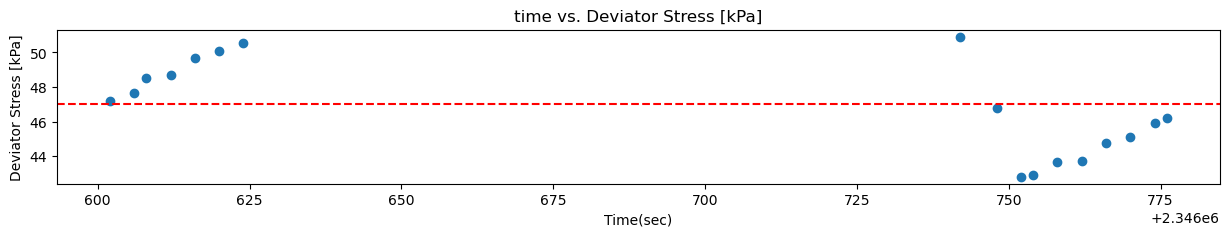

In [8]:
# The data for fitting
#['Local Axial 2 (mm)']
time = df_NC04_new.loc[: ,'Time since start of test (s)']
stress = df_NC04_new.loc[: ,'Axial Stress (kPa)']

###### Plot the data for several loops ################################# 236899
X1 =3468  #10000
X2 =3469 #10030

loop_indices = list(range(X1, X2)) 


plt.figure(figsize=(15, 2))

for i in loop_indices:
    if i < len(cycles_NC04):
      time_values = cycles_NC04[i]['Time since start of test (s)']
      stress_values = cycles_NC04[i]['Deviator Stress (kPa)']
      plt.scatter(time_values, stress_values)

plt.xlabel("Time(sec)")
plt.ylabel('Deviator Stress [kPa]')
plt.title('time vs. Deviator Stress [kPa]')
plt.axhline(y=mean_val_NC04_P, color='r', linestyle='--', label='Mean Value')
plt.show()

In [9]:
print(f'The number of crossing points before the filtering: {len(crossing_df_NC04)} point')
print(f'The number of crossing points before the filtering : {len(filtered_crossing_df_NC04)} points')

print(f'The number of cycles: {len(cycles_NC04)} cycles')
print(f'The number of data rows: {len(df_NC04_new)} cycles')

df_NC04_new.columns
df_NC04_new[8847:8887]
#cycles_NC04[0]  

The number of crossing points before the filtering: 16298 point
The number of crossing points before the filtering : 16297 points
The number of cycles: 8148 cycles
The number of data rows: 460748 cycles


,Stage Number,Cycle nr,Time since start of test (s),Time since start of stage (s),Radial Pressure (kPa),Radial Volume (mm³),Back Pressure (kPa),Back Volume (mm³),Load Cell (kN),Pore Pressure (kPa),...,kRT constant,Global Axial Strain,Axial Stress & Uncertainty (kPa),Global Axial Strain & Uncertainty,Radial Pressure & Uncertainty (kPa),Error Deviator Stress (kPa),Deviator Stress & Uncertainty (kPa),Pore Pressure & Uncertainty (kPa),Eff. Stress & Uncertainty (kPa),Cycle time
8847,1,NaN,530820,530820,124,-25041,79.8,-3819,0.0548,79.498,...,1,0.0156,152.0083+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.50+/-0.28,53.8+/-0.8,NaN
8848,1,NaN,530880,530880,124,-25042,79.8,-3818,0.0548,79.348,...,1,0.0156,152.0075+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.35+/-0.28,54.0+/-0.8,NaN
8849,1,NaN,530940,530940,124,-25046,79.8,-3818,0.0548,79.498,...,1,0.0156,152.0075+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.50+/-0.28,53.8+/-0.8,NaN
8850,1,NaN,531000,531000,124,-25050,80.0,-3817,0.0548,79.348,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.35+/-0.28,54.0+/-0.8,NaN
8851,1,NaN,531060,531060,124,-25054,80.0,-3817,0.0548,79.498,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.50+/-0.28,53.8+/-0.8,NaN
8852,1,NaN,531120,531120,124,-25056,79.9,-3817,0.0548,79.498,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.50+/-0.28,53.8+/-0.8,NaN
8853,1,NaN,531180,531180,124,-25060,80.0,-3817,0.0548,79.348,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.35+/-0.28,54.0+/-0.8,NaN
8854,1,NaN,531240,531240,124,-25066,80.0,-3817,0.0548,79.348,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.35+/-0.28,54.0+/-0.8,NaN
8855,1,NaN,531300,531300,124,-25072,80.0,-3817,0.0548,79.348,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.35+/-0.28,54.0+/-0.8,NaN
8856,1,NaN,531360,531360,124,-25077,79.8,-3817,0.0548,79.498,...,1,0.0156,152.0067+/-0,0.015600+/-0.000004,124.0+/-1.1,1.0664,28.0+/-1.1,79.50+/-0.28,53.8+/-0.8,NaN


# Stage info 

In [10]:
df = df_NC04_new[:].reset_index()
cycles_data = cycles_NC04
name =  'NC04'
P0q0_stage_nr = 2
qm_stage_nr =  4 
line_ranges = [(4, 4)]  # The range of Stage loading for each stage number. 
qf = qf_NC
Su = Su_NC
Stage_info_all_NC04 = calculate_stage_info_all(df, cycles_data, name, P0q0_stage_nr, qm_stage_nr, qf, Su)
Stage_info_all_NC04

,Sample type,Stage Number,Start index,End index,Rows nr,Start time,End time,Test duration(d),Cyclic loading duration(d),Cycles nr,...,q_p,q_m,q_min,q_max,q_avg,qcyc,qcyc/p0,CSR,qc/2Su,qm/2Su
0,NC04,1,0,8882,8883,0,532921,6.168067,0.000000,0,...,0,0,0,0,0,0.0,0,0,0,0
1,NC04,2,8883,9060,178,532920,533900,0.011343,0.000000,0,...,19.0+/-1.5,47.0+/-1.1,0,0,0,0.0,0.0+/-0,0,0,0.712+/-0.016
2,NC04,3,9061,28884,19824,533906,1722350,13.755139,0.000000,0,...,0,0,0,0,0,0.0,0,0,0,0
3,NC04,4,28885,439870,410986,1722356,3189337,16.978947,16.978947,8148,...,19.0+/-1.5,47.0+/-1.1,42.050+/-0.012,51.978+/-0.012,47.0135+/-0.0017,4.964+/-0.008,0.0922+/-0.0013,0.03761+/-0.00006,0.07521+/-0.00013,0.712+/-0.016
4,NC04,5,439871,460747,20877,3189342,3293660,1.207384,0.000000,0,...,0,0,0,0,0,0.0,0,0,0,0


In [11]:
Stage_info_NC04 = calculate_stage_info(df, cycles_data, name, P0q0_stage_nr, qm_stage_nr, qf, Su, line_ranges)
# Export this DataFrame to a CSV file
Path_Stage_info_NC04 = os.path.join('Outputs_csv', 'Stage_info_NC04.csv')
Stage_info_NC04.to_csv(Path_Stage_info_NC04, index=False)
Stage_info_NC04

,Sample type,Stage Number,Start index,End index,Rows nr,Star time,End time,Test duration(d),Cyclic loading duration(d),Cycles nr,...,q_m,q_p,q_min,q_max,q_avg,qcyc,qcyc/p0,CSR,qc/2Su,qm/2Su
0,NC04,1,28885,439870,410986,1722356,3189337,38.12088,16.978947,8148,...,47.0+/-1.1,19.0+/-1.5,42.050+/-0.012,51.978+/-0.012,47.0135+/-0.0017,4.964+/-0.008,0.0922+/-0.0013,0.03761+/-0.00006,0.07521+/-0.00013,0.712+/-0.016


# Stress-strain Cycle - Fit Ellispe

## Global cycles

### Single Cycle


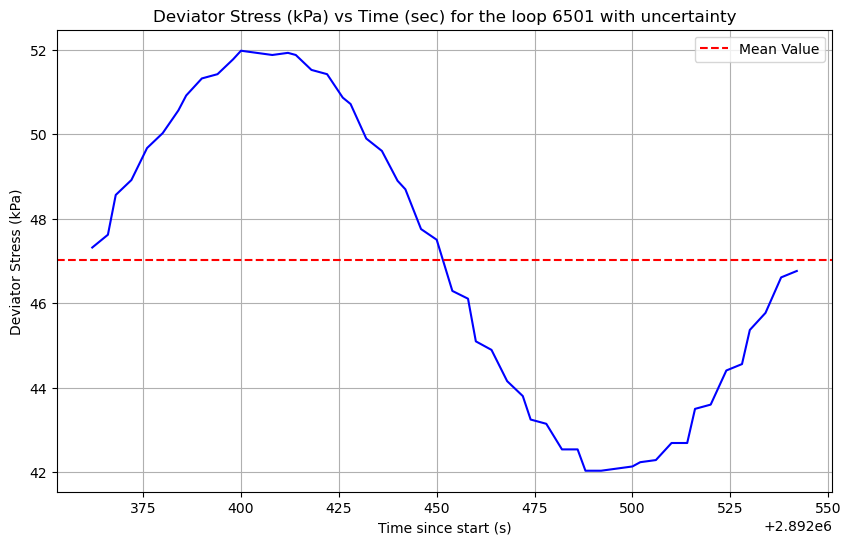

qmax: 52.0+/-1.1
qmin: 42.0+/-1.1
qcyc: 5.0+/-0.8
pwp_NC04: 104.72+/-0.05
delta_pwp_NC04: 3.74+/-0.07


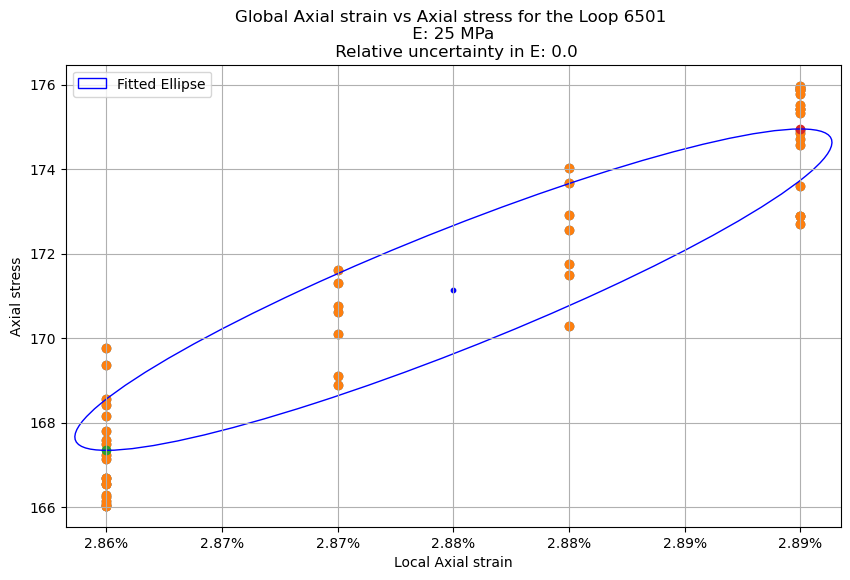

min_x: 0.0286
max_x: 0.028900000000000002
min_y: 167.3428088547305
max_y: 174.94857843689113

E: 25.35256527386864 MPa
E error: 0.0068216776364704995 MPa
shear_modulus_mPa: 10.563568864111932

angle 89.99774004015514
prefixed_major_axis_length 7.605769672160633
minor_axis_length 0.00013061781608937026
Centriod 2.8750+/-0.0008 0.1711456936458108+/-0
width_x 0.00030000000000000165
height_y_MPa 0.007605769582160633

CSR :0.038+/-0.006
qcyc/po :0.092+/-0.014
qcyc/2su :0.075+/-0.011
qm / 2su :0.712+/-0.016

shear_strain :3.4500+/-0.0009
shear_strain :3.4500+/-0.0009


In [12]:
#The loop number i+1: 
i = 6500
f_b = 3

time = cycles_NC04[i]['Time since start of test (s)']
deviator_stress = cycles_NC04[i]['Deviator Stress (kPa)']
yerr = cycles_NC04[i]['Error Deviator Stress (kPa)']

x_values = cycles_NC04[i]['Global Axial Strain'].tolist()     ## Axial Strain 
y_values = cycles_NC04[i]['Axial Stress (kPa)'].tolist()     ## Axial Stress kPa

plt.figure(figsize=(10, 6))
#plt.errorbar(time, deviator_stress, yerr = yerr, fmt='.', linewidth=2, capsize=6) 
plt.plot(time, cycles_NC04[i]['Deviator Stress (kPa)'], color='blue')
plt.xlabel("Time since start (s)")
plt.ylabel("Deviator Stress (kPa)")
plt.axhline(mean_val_NC04_P, color='r', linestyle='--', label='Mean Value')
plt.legend()
plt.title(f'Deviator Stress (kPa) vs Time (sec) for the loop {i+1} with uncertainty')
plt.grid(True)
plt.show()


## the cycle amplitude 
qmax = np.max(cycles_NC04[i]['Deviator Stress & Uncertainty (kPa)'])
qmin = np.min(cycles_NC04[i]['Deviator Stress & Uncertainty (kPa)'])
qcyc = (qmax - qmin) / 2

print("qmax:", qmax) 
print("qmin:", qmin) 
print("qcyc:", qcyc) 

pwp_NC04 =  umean(cycles_NC04[i]['Pore Pressure & Uncertainty (kPa)'])
delta_pwp_NC04 = umean(cycles_NC04[i]['Pore Pressure & Uncertainty (kPa)']) - umean(cycles_NC04[0]['Pore Pressure & Uncertainty (kPa)'])
print("pwp_NC04:", pwp_NC04)
print("delta_pwp_NC04:", delta_pwp_NC04)


###############
# Filter the outliers in the cycle
#########################################

x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = (
Filter_outliers(x_values, y_values, f_b) )

#########################################
# Plot the fit ellipse   #####################
#########################################

# Fit an ellipse model using RANSAC
model = EllipseModel()
points = np.column_stack((x_o, y_o))
model.estimate(points)
center = model.params[0:2]
center_projection_x = center[0]
center_projection_y = center[1]
major_axis_length = model.params[2] * 2
minor_axis_length = model.params[3] * 2
angle = np.degrees(model.params[4])
prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )

## The centriod and lateral values with uncertainty 
Error_C_x = abs(Cx_l * Ru_strain_G_NC04)                       ####
Error_C_y = abs(Cy_l * Ru_stress_NC04)                         ####


C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

height_y = abs(max_y - min_y)
height_y_MPa = height_y / 1000     ## MPa
width_x  = abs(max_x - min_x)

E =  height_y_MPa / width_x  ## MPa
E_error = E *  Ru_E_G_NC04                                                              ####
E_U = ufloat(E, E_error)                                                          

ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
tri_area = 0.5 * (height_y) * (width_x)
damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 

shear_modulus_mPa = E / (2*(1+v))  ## MPa

shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress

CSR      = qcyc / (2* qf_NC)
qcyc_po  = qcyc /(Stage_info_NC04.loc[0]['p_0'])
qcyc_2su = qcyc / (2 * Su_NC)
qm_2su   = (Stage_info_NC04.loc[0]['q_m'])/ (2 * Su_NC)


plt.figure(figsize=(10, 6))            
plt.scatter(x_values, y_values)
plt.scatter(x_o, y_o)
plt.scatter(min_x, min_y)
plt.scatter(max_x, max_y)
plt.scatter(Cx_l, Cy_l, s=10, c='b', marker='o')
ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = False, label='Fitted Ellipse')
plt.gca().add_patch(ellipse_cstr)
#plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100))  # Set max to 100%
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages
plt.xlabel('Local Axial strain')
plt.ylabel('Axial stress')
plt.title(f'Global Axial strain vs Axial stress for the Loop {i+1} \n E: {E:.0f} MPa \n Relative uncertainty in E: {Ru_E_G_NC04:.1f}')
plt.grid(True)
plt.legend()
plt.show()

print(f'min_x: {min_x}')
print(f'max_x: {max_x}')
print(f'min_y: {min_y}')
print(f'max_y: {max_y}')
print()
print(f'E: {E} MPa')
print(f'E error: {E_error} MPa') 
print(f'shear_modulus_mPa: {shear_modulus_mPa}') 
print()
print(f"angle", angle_in_degrees)
print(f"prefixed_major_axis_length", prefixed_major_axis_length)
print(f"minor_axis_length", prefixed_minor_axis_length)
print(f"Centriod", C_X,C_Y_MPa)
print(f"width_x", width_x)
print(f"height_y_MPa", height_y_MPa)
print()
print(f'CSR :{CSR}')
print(f'qcyc/po :{qcyc_po }')
print(f'qcyc/2su :{qcyc_2su}')
print(f'qm / 2su :{qm_2su  }')
print()
print(f'shear_strain :{shear_strain}')
print(f'shear_strain :{shear_strain }')


### All Cycles

In [13]:
# For each loop, get the start and end times
#plt.figure(figsize=(10, 6))   
f_b = 100
cycle_info_NC04 = []
for n, loop in enumerate(cycles_NC04):
  try:
    start_time = loop.iloc[0,2]
    end_time = loop.iloc[-1,2]
        

    x_values = cycles_NC04[n]['Global Axial Strain'].tolist()     ## Axial Strain 
    y_values = cycles_NC04[n]['Deviator Stress (kPa)'].tolist()     ## Axial Stress kPa 
    
    ## the cycle amplitude 
    qmax = np.max(cycles_NC04[n]['Deviator Stress & Uncertainty (kPa)'])
    qmin = np.min(cycles_NC04[n]['Deviator Stress & Uncertainty (kPa)'])
    qcyc = (qmax - qmin) / 2
    
        
    ## Excess pore water pressure
    pwp =  umean(cycles_NC04[n]['Pore Pressure & Uncertainty (kPa)'])
    pwp0 = umean(cycles_NC04[0]['Pore Pressure & Uncertainty (kPa)'])
    delta_pwp = pwp - pwp0
    
    
    ## Loading period T and Frequency of loading f
    Tmax = np.max(cycles_NC04[n]['Time since start of test (s)'])
    Tmin = np.min(cycles_NC04[n]['Time since start of test (s)'])  
    T = Tmax - Tmin  
    f = 1 / T
    

    ################################
    # Ellipse calculation    #######
    ################################
    #########################################
        
    ###############
    # Filter the outliers in the cycle
    #########################################
    x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = ( Filter_outliers(x_values, y_values, f_b) )
    
    #########################################
    # Plot the fit ellipse   ################
    #########################################
    
    # Fit an ellipse model using RANSAC
    model = EllipseModel()
    points = np.column_stack((x_o, y_o))
    model.estimate(points)
    center = model.params[0:2]
    center_projection_x = center[0]
    center_projection_y = center[1]
    major_axis_length = model.params[2] * 2
    minor_axis_length = model.params[3] * 2
    angle = np.degrees(model.params[4])
    prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )
    
    ## The centriod and lateral values with uncertainty 
    Error_C_x = abs(Cx_l * Ru_strain_G_NC04)
    Error_C_y = abs(Cy_l * Ru_stress_NC04)

    C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
    C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

    
    height_y = abs(max_y - min_y)
    height_y_MPa = height_y / 1000     ## MPa
    width_x  = abs(max_x - min_x)
    
    E =  height_y_MPa / width_x  ## MPa
    E_error = E *  Ru_E_G_NC04                                                              ####
    E_U = ufloat(E, E_error)       
    
    ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
    tri_area = 0.5 * (height_y) * (width_x)
    damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 
    
    shear_modulus_mPa = E / (2*(1+v))  ## MPa
    
    shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
    shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress
    
    CSR      = qcyc / (2* qf_NC)
    qcyc_po  = qcyc / (Stage_info_NC04.loc[0]['p_0'])
    qcyc_2su = qcyc / (2 * Su_NC)
    qm_2su   = Stage_info_NC04.loc[0]['q_m'] / (2 * Su_NC)
            
            
    # Append the loop information to the list
    cycle_info_NC04.append([n+1, start_time, end_time, ellipse_area, tri_area, damping_ratio, C_X, C_Y_MPa, width_x, height_y_MPa, shear_strain, shear_stress_mPa, E, E_error, E_U, shear_modulus_mPa, qmax, qmin, qcyc, pwp, delta_pwp, qm_2su, qcyc_2su, qcyc_po, CSR, T, f])
    
    #plt.scatter(Cx_l, Cy_l, s=10, c='r', marker='o', zorder=2)
    #ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = False, label='Fitted Ellipse', zorder=1)
    #plt.gca().add_patch(ellipse_cstr)

  except Exception as e:  # Catch any exceptions during processing
   print(f"Error encountered for loop {n}: {e}")
   pass  # Continue to the next loop iteration 
    
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages   
#plt.xlabel('Axial strain [%]')
#plt.ylabel('Axial stress [kPa]')
#plt.title(f"Axial strain [%] vs Axial stress [kPa] for {n+1} cycles - sample NC04")
#plt.grid(True)
#plt.show()    

# Convert loop_info to a DataFrame
cycle_info_NC04_G  = pd.DataFrame(cycle_info_NC04[:], columns=['Loop_Number', 'Start_Time', 'End_Time', 'Ellipse_area', 'Triangle_area', 'Damping_ratio', 'C_X(%)' ,'C_Y(MPa)', 'Delta_x', 'Delta_y(MPa)', 'Shear Strain', 'Shear Stress(mPa)', 'E(MPa)', 'E_error', 'E_u (MPa)', 'Shear_modulus_(MPa)', 'qmax', 'qmin', 'qcyc', 'pwp', 'delta_pwp', 'qm/2su', 'qcyc/2su', 'qcyc/po', 'CSR', 'T_(s)', 'f(Hz)'])

# Split the DataFrame into two parts
split_index = 10065
cycle_info_NC04_G_1 = cycle_info_NC04_G.iloc[:split_index]
cycle_info_NC04_G_2 = cycle_info_NC04_G.iloc[split_index:]

# Export this DataFrame to a CSV file
Path_cycle_info_NC04_G = os.path.join('Outputs_csv', 'cycle_info_NC04_G.csv')
cycle_info_NC04_G.to_csv(Path_cycle_info_NC04_G, index=False)


In [14]:
#cycle_info_G_NC04_2[0:30]
cycle_info_NC04_G_1[0:20]    

,Loop_Number,Start_Time,End_Time,Ellipse_area,Triangle_area,Damping_ratio,C_X(%),C_Y(MPa),Delta_x,Delta_y(MPa),...,qmin,qcyc,pwp,delta_pwp,qm/2su,qcyc/2su,qcyc/po,CSR,T_(s),f(Hz)
0,1,1722364,1722540,0.000910,0.001196,0.242155,2.4850+/-0.0007,0.04691605750000025+/-0,0.0003,0.007976,...,42.1+/-1.1,4.9+/-0.8,100.99+/-0.05,0.00+/-0.07,0.712+/-0.016,0.074+/-0.011,0.091+/-0.014,0.037+/-0.006,176,0.005682
1,2,1722544,1722716,0.000907,0.001245,0.231831,2.4850+/-0.0007,0.046911139643917125+/-0,0.0003,0.008299,...,42.0+/-1.1,4.9+/-0.8,100.95+/-0.05,-0.03+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.037+/-0.006,172,0.005814
2,3,1722720,1722896,0.000877,0.001196,0.233411,2.4850+/-0.0007,0.04695440151673648+/-0,0.0003,0.007971,...,42.0+/-1.1,4.9+/-0.8,100.98+/-0.05,-0.01+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.037+/-0.006,176,0.005682
3,4,1722900,1723078,0.000808,0.001192,0.215936,2.4850+/-0.0007,0.046794615617805166+/-0,0.0003,0.007945,...,42.0+/-1.1,5.0+/-0.8,100.99+/-0.05,0.00+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.038+/-0.006,178,0.005618
4,5,1723080,1723258,0.000829,0.001183,0.223156,2.4850+/-0.0007,0.046803326157585215+/-0,0.0003,0.007885,...,42.0+/-1.1,5.0+/-0.8,101.00+/-0.05,0.02+/-0.07,0.712+/-0.016,0.076+/-0.011,0.093+/-0.014,0.038+/-0.006,178,0.005618
5,6,1723262,1723438,0.000823,0.001235,0.212121,2.4850+/-0.0007,0.04672775400000006+/-0,0.0003,0.008230,...,42.1+/-1.1,4.9+/-0.8,101.00+/-0.05,0.01+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.037+/-0.006,176,0.005682
6,7,1723442,1723620,0.001313,0.002056,0.203361,2.4900+/-0.0007,0.04789195688536415+/-0,0.0004,0.010279,...,42.0+/-1.1,5.0+/-0.8,101.00+/-0.05,0.02+/-0.07,0.712+/-0.016,0.075+/-0.011,0.093+/-0.014,0.038+/-0.006,178,0.005618
7,8,1723624,1723800,0.001132,0.001948,0.185015,2.4900+/-0.0007,0.04770003571428578+/-0,0.0004,0.009741,...,42.0+/-1.1,5.0+/-0.8,101.03+/-0.05,0.04+/-0.07,0.712+/-0.016,0.075+/-0.011,0.093+/-0.014,0.038+/-0.006,176,0.005682
8,9,1723804,1723978,0.001110,0.001966,0.179822,2.4900+/-0.0007,0.04766827471640488+/-0,0.0004,0.009828,...,42.0+/-1.1,5.0+/-0.8,101.04+/-0.05,0.05+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.038+/-0.006,174,0.005747
9,10,1723982,1724158,0.001124,0.001908,0.187475,2.4900+/-0.0007,0.04763840895308345+/-0,0.0004,0.009540,...,42.1+/-1.1,5.0+/-0.8,101.03+/-0.05,0.04+/-0.07,0.712+/-0.016,0.075+/-0.011,0.092+/-0.014,0.038+/-0.006,176,0.005682


## Max & Min Error in E

In [15]:
E_max = np.max(cycle_info_NC04_G['E(MPa)'])
print(f'max E : {E_max}') 
E_min = np.min(cycle_info_NC04_G['E(MPa)'])
print(f'min E : {E_min}')

max E : 28.37069964243159
min E : 17.736546845124142


In [16]:
E_error_max = np.max(cycle_info_NC04_G['E_error'])
print(f'max error : {E_error_max}')
E_error_min = np.min(cycle_info_NC04_G['E_error'])
print(f'min error : {E_error_min}')


max error : 0.007633774538834462
min error : 0.004772416662952229


## The cycle number which has largest Error

In [17]:
# Find index where 'Ru_E(%)' equals 11120.814809156738
index = np.where(cycle_info_NC04_G['E_error'] == np.max(cycle_info_NC04_G['E_error']))[0]
print(f"The index where 'E_error' equals  is {index}.")

The index where 'E_error' equals  is [6260].


## The cycle numbers which has largest of value of Error


In [18]:
index = cycle_info_NC04_G[cycle_info_NC04_G['E_error'] >= 1].index
print(len(index))
print(f"The index where 'E_error' is greater than or equal to n is: {index.tolist()}")


0
The index where 'E_error' is greater than or equal to n is: []


###################################################################################
####################################################################################